# Regression Plots

In [1191]:
%matplotlib inline
# 用于在 Jupyter Notebook 中内嵌显示 Matplotlib 绘制的图形。

In [1192]:
from statsmodels.compat import lzip
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

# runtime configuration（运行时配置）
# 设置图形的默认尺寸，使得每次绘图时都使用 16x8 英寸的尺寸
plt.rc("figure", figsize=(16, 8))
# 设置字体的默认大小
plt.rc("font", size=14)

## Duncan's Prestige Dataset

### Load the Data

We can use a utility function to load any R dataset available from the great <a href="https://vincentarelbundock.github.io/Rdatasets/">Rdatasets package</a>.

In [1193]:
prestige = sm.datasets.get_rdataset("Duncan", "carData", cache=True).data
# help(sm.datasets.get_rdataset)

In [1194]:
prestige.head(10)
#print(prestige)
#

type  income  education  prestige
rownames                                     
accountant  prof      62         86        82
pilot       prof      72         76        83
architect   prof      75         92        90
author      prof      55         90        76
chemist     prof      64         86        90
minister    prof      21         84        87
professor   prof      64         93        93
dentist     prof      80        100        90
reporter      wc      67         87        52
engineer    prof      72         86        88

In [1195]:
prestige_model = ols("prestige ~ income + education", data=prestige).fit()

In [1196]:
# 总结
print(prestige_model.summary())

                            OLS Regression Results                            
Dep. Variable:               prestige   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     101.2
Date:                Thu, 25 Jul 2024   Prob (F-statistic):           8.65e-17
Time:                        18:55:13   Log-Likelihood:                -178.98
No. Observations:                  45   AIC:                             364.0
Df Residuals:                      42   BIC:                             369.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.0647      4.272     -1.420      0.1

### Influence plots

Influence plots show the (externally) studentized residuals vs. the leverage of each observation as measured by the hat matrix.

Externally studentized residuals are residuals that are scaled by their standard deviation where 

$$var(\hat{\epsilon}_i)=\hat{\sigma}^2_i(1-h_{ii})$$

with

$$\hat{\sigma}^2_i=\frac{1}{n - p - 1 \;\;}\sum_{j}^{n}\;\;\;\forall \;\;\; j \neq i$$

$n$ is the number of observations and $p$ is the number of regressors. $h_{ii}$ is the $i$-th diagonal element of the hat matrix

$$H=X(X^{\;\prime}X)^{-1}X^{\;\prime}$$

The influence of each point can be visualized by the criterion keyword argument. Options are Cook's distance and DFFITS, two measures of influence.

>> - 高杠杆值的点对模型拟合有较大影响
>> - 学生化残差高的点表示模型的拟合在该观测点上有较大误差

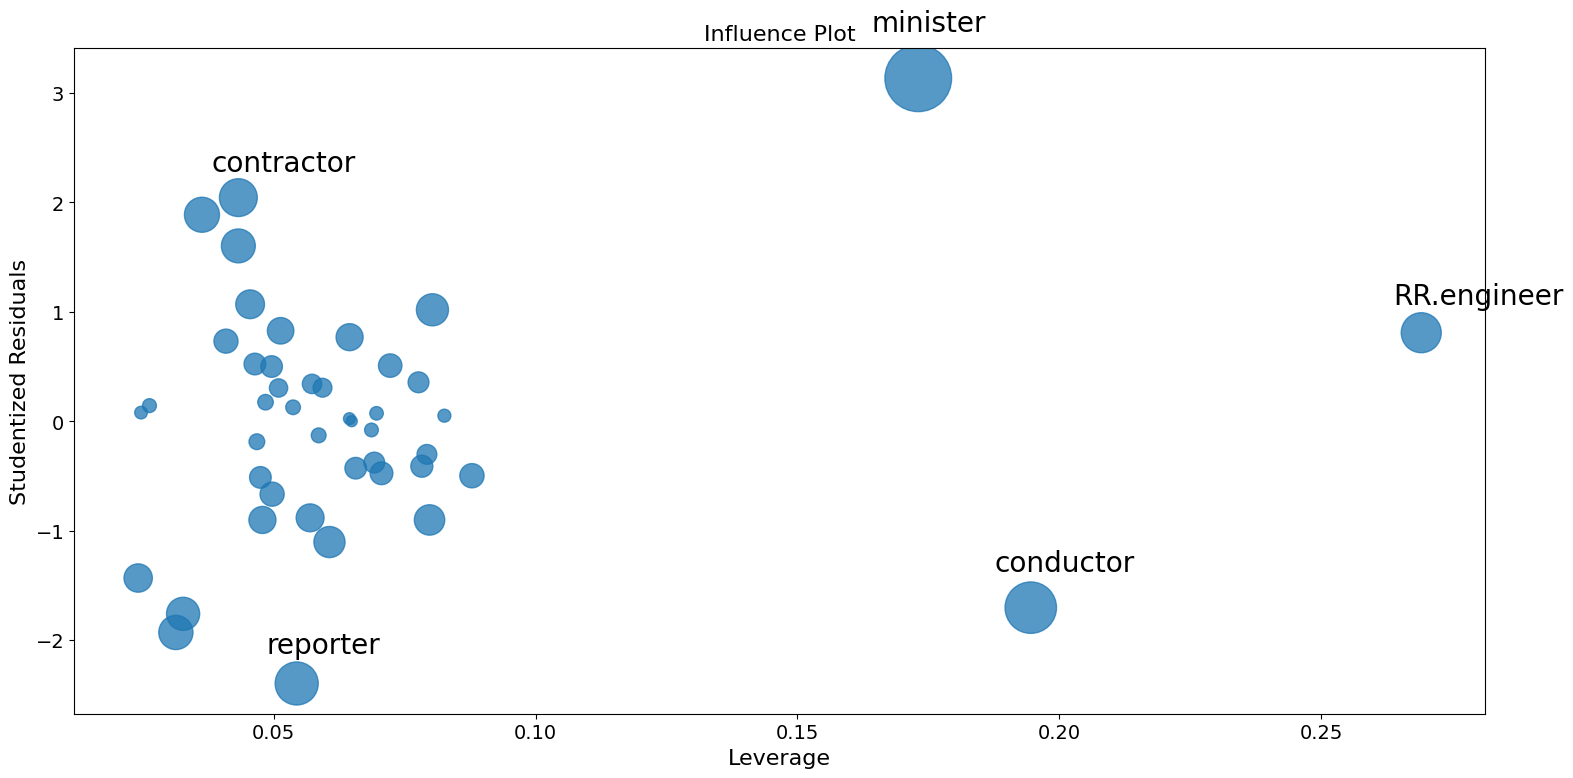

In [1197]:
#fig = sm.graphics.influence_plot(prestige_model, criterion="cooks")
fig = sm.graphics.influence_plot(prestige_model, criterion="DFFITS",size=48)
# 
fig.tight_layout(pad=1.0)

As you can see there are a few worrisome observations. Both contractor and reporter have low leverage but a large residual. <br />
RR.engineer has small residual and large leverage. Conductor and minister have both high leverage and large residuals, and, <br />
therefore, large influence.

### Partial Regression Plots (Duncan)

Since we are doing multivariate regressions, we cannot just look at individual bivariate plots to discern relationships. <br />
Instead, we want to look at the relationship of the dependent variable and independent variables conditional on the other <br />
independent variables. We can do this through using partial regression plots, otherwise known as **added variable plots**. <br />

>> - 控制其他变量。

In a partial regression plot, to discern the relationship between the response variable and the $k$-th variable, we compute <br />
the residuals by regressing the response variable versus the independent variables excluding $X_k$. We can denote this by <br />
$X_{\sim k}$. We then compute the residuals by regressing $X_k$ on $X_{\sim k}$. The partial regression plot is the plot <br />
of the former versus the latter residuals. <br />

>> - 比如说跑prestige & income 的时候，控制education的影响？

The notable points of this plot are that the fitted line has slope $\beta_k$ and intercept zero. The residuals of this plot <br />
are the same as those of the least squares fit of the original model with full $X$. You can discern the effects of the <br />
individual data values on the estimation of a coefficient easily. If obs_labels is True, then these points are annotated <br />
with their observation label. You can also see the violation of underlying assumptions such as homoskedasticity and <br />
linearity.

>> - 拟合的斜率为0

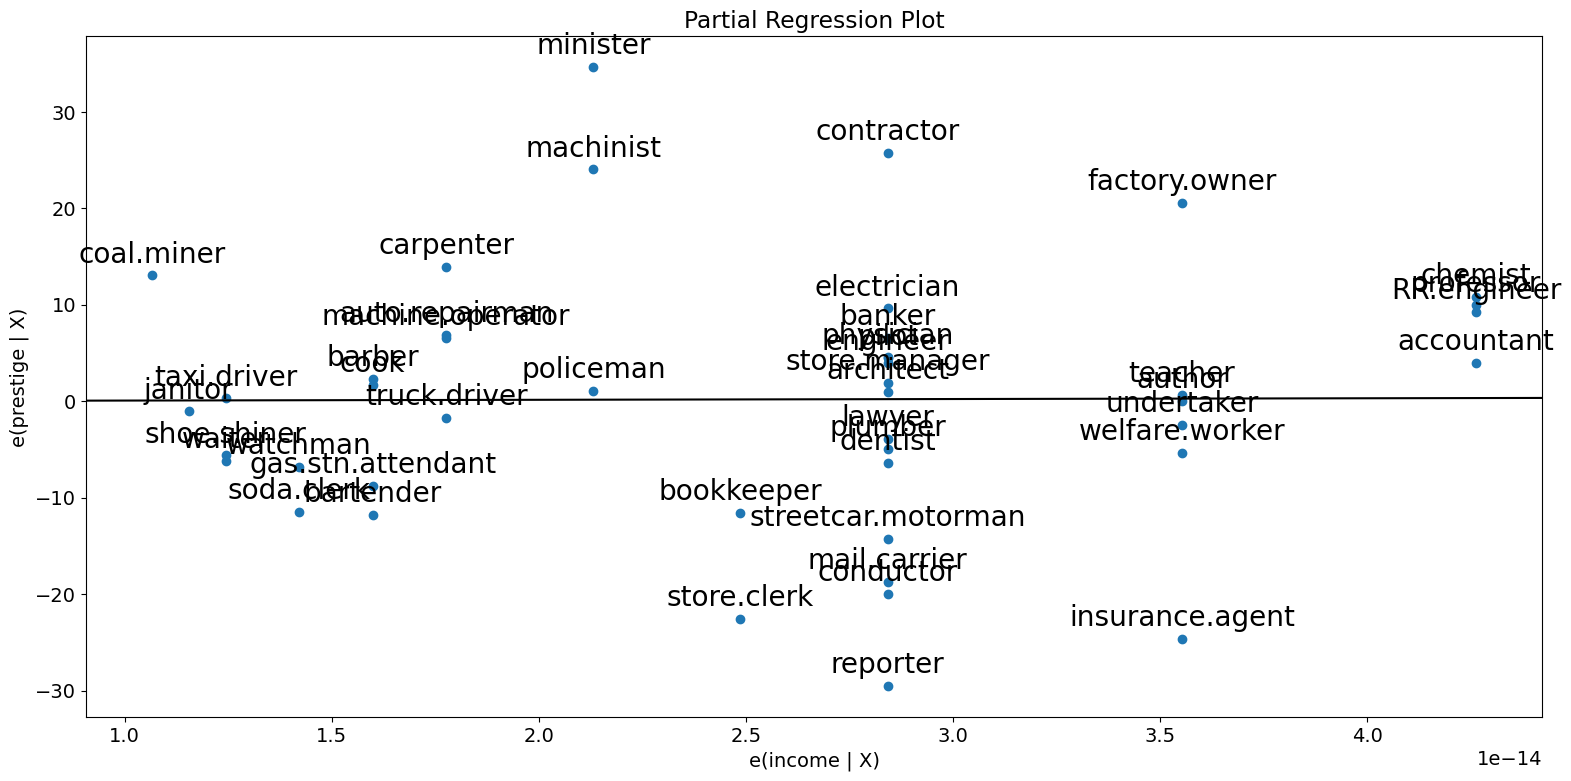

In [1198]:
# 分析 income 与 prestige 关系时，已经控制了education对于收入的影响。
fig = sm.graphics.plot_partregress(
    "prestige", "income", ["income", "education"], data=prestige,obs_labels=True
)

fig.tight_layout(pad=1.0)
#help(sm.graphics.plot_partregress)

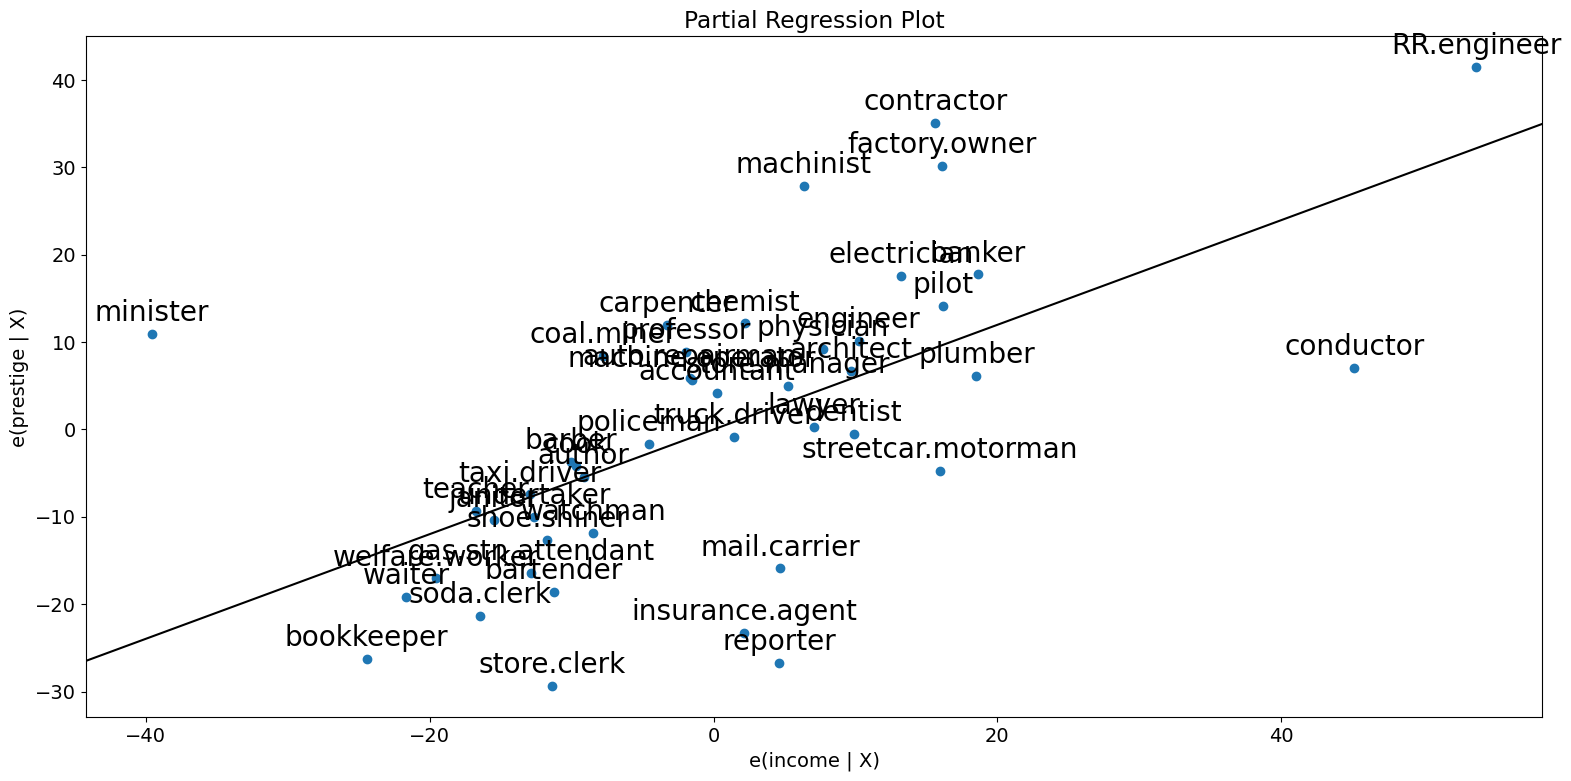

In [1199]:
# 如果不分别控制教育呢
fig = sm.graphics.plot_partregress("prestige", "income", ["education"], data=prestige)
fig.tight_layout(pad=1.0)


As you can see the partial regression plot confirms the **influence of conductor, minister, and RR.engineer** on the partial relationship between income and prestige. The cases greatly decrease the effect of income on prestige. Dropping these cases confirms this.

>> - 结果主要是 conductor, minister, and RR.engineer 驱动的，下文证明

In [1200]:
# 索引prestage里面是否有三个变量
# \~非运算符，把返回的bool值反转，然后标记出来，除掉他们
subset = ~prestige.index.isin(["conductor", "RR.engineer", "minister"])
prestige_model2 = ols(
    "prestige ~ income + education", data=prestige, subset=subset
).fit()
print(prestige_model2.summary())

                            OLS Regression Results                            
Dep. Variable:               prestige   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     138.1
Date:                Thu, 25 Jul 2024   Prob (F-statistic):           2.02e-18
Time:                        18:55:14   Log-Likelihood:                -160.59
No. Observations:                  42   AIC:                             327.2
Df Residuals:                      39   BIC:                             332.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.3174      3.680     -1.717      0.0

For a quick check of all the regressors, you can use plot_partregress_grid. These plots will not label the <br />
points, but you can use them to identify problems and then use plot_partregress to get more information.

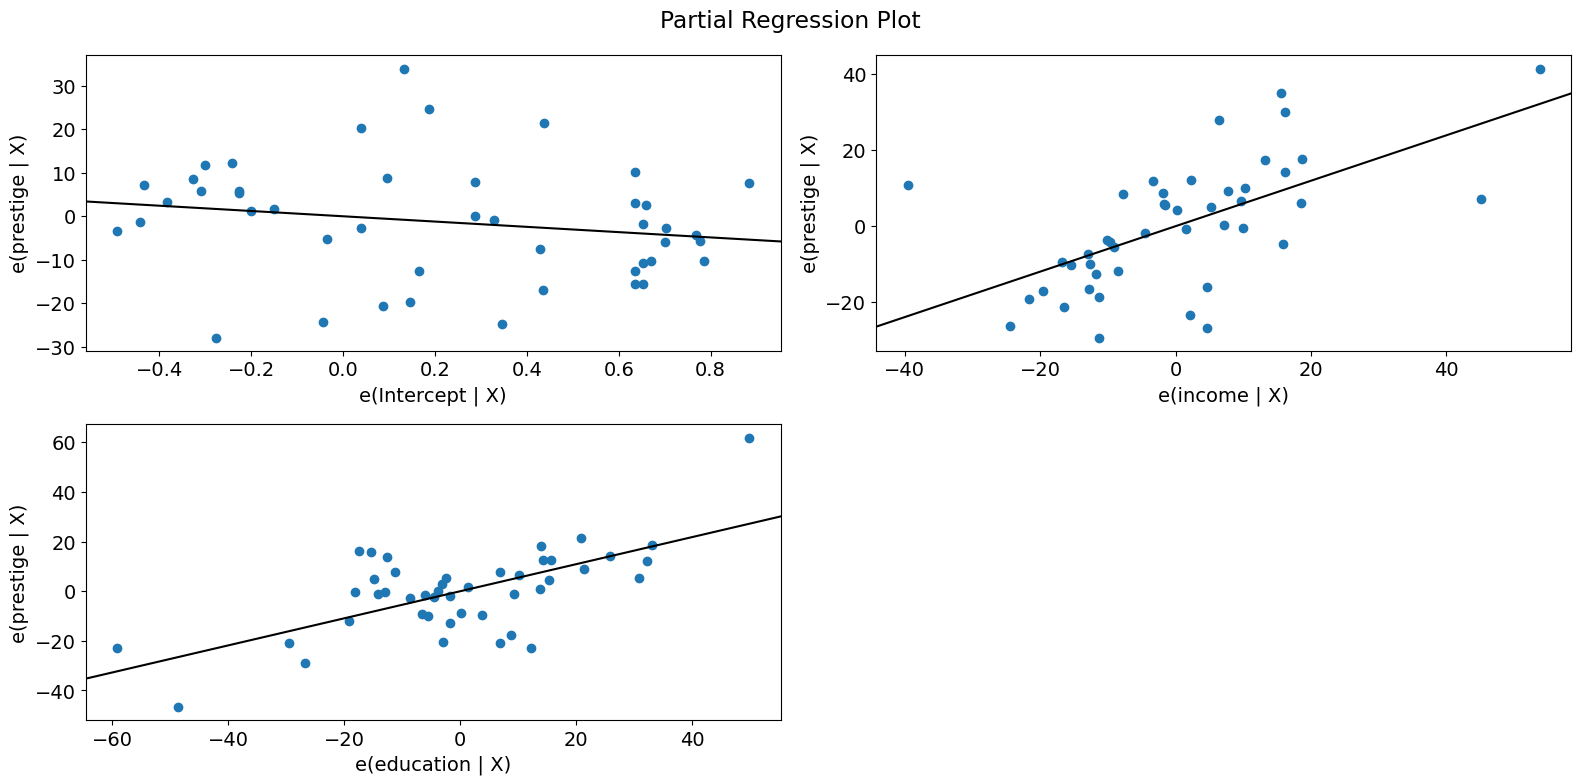

In [1201]:
fig = sm.graphics.plot_partregress_grid(prestige_model)
fig.tight_layout(pad=1.0)

### Component-Component plus Residual (CCPR) Plots

The CCPR plot provides a way to judge the effect of one regressor on the response variable by taking into account the effects of the other independent variables. 

>> - 考虑其他的解释变量

The partial residuals plot is defined as $\text{Residuals} + B_iX_i \text{ }\text{ }$   versus $X_i$.
The component adds $B_iX_i$ versus $X_i$ to show where the fitted line would lie. 


Care should be taken if $X_i$ is highly correlated with any of the other independent variables. If this is the case, the variance evident in the plot will be an underestimate of the true variance.

>> - 要小心$X_i$ 和其他解释变量相关 (bad control?)

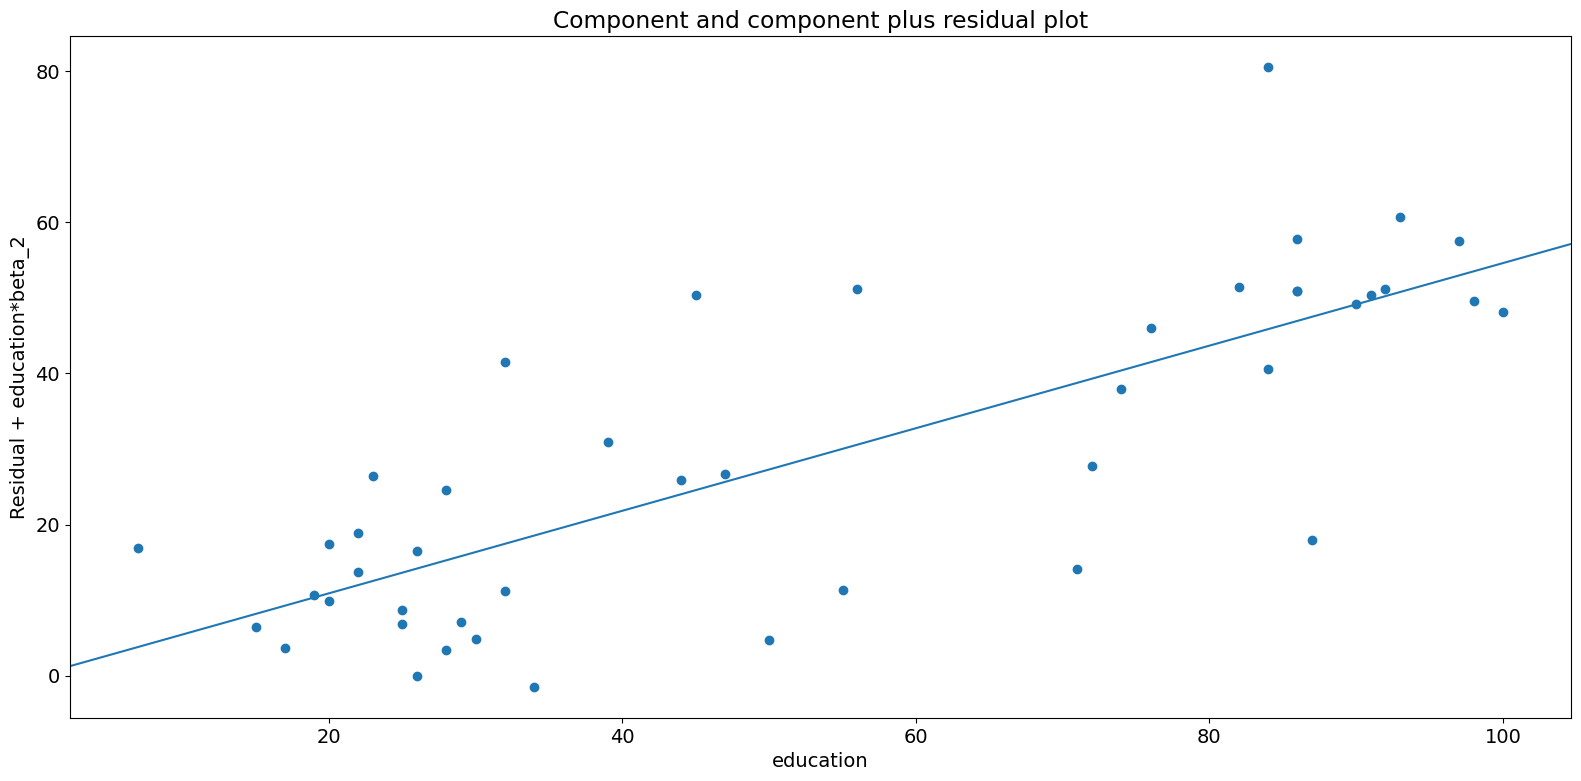

In [1202]:
# 考虑教育对收入的影响
fig = sm.graphics.plot_ccpr(prestige_model, "education")
# 这样y轴就相当于y = beta*eduction + error term
fig.tight_layout(pad=1.0)

As you can see the relationship between the variation in prestige explained by education conditional on income seems to be linear, though you can see there are some observations that are exerting considerable influence on the relationship. 

>> - 发现控制了教育对于收入的影响后，prestige和income确实是线性的。

We can quickly look at more than one variable by using plot_ccpr_grid.

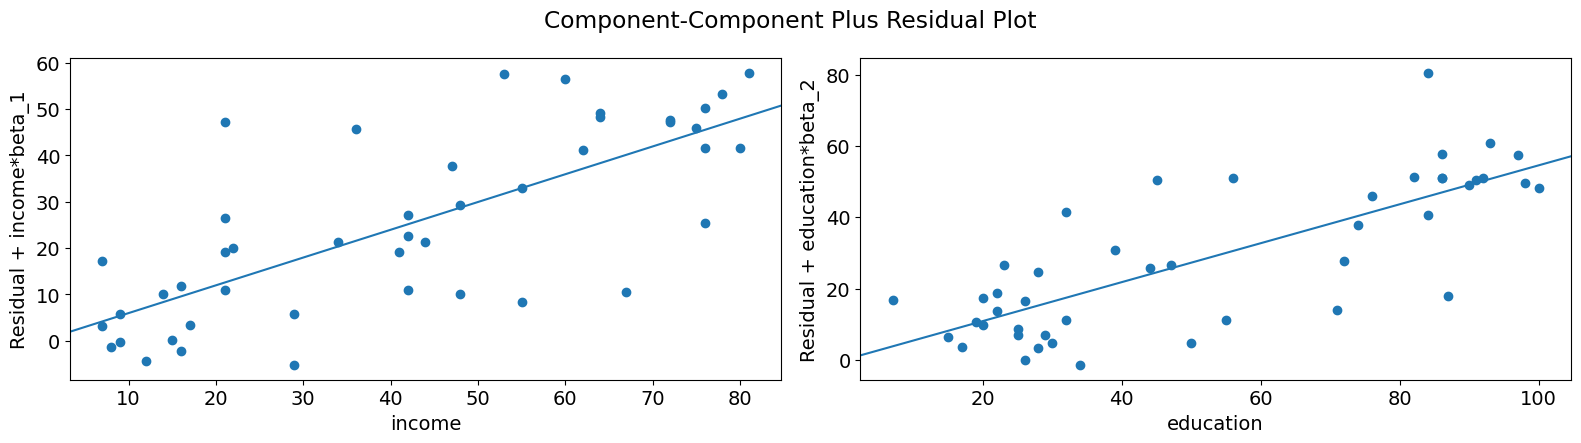

In [1203]:
fig = sm.graphics.plot_ccpr_grid(prestige_model)
fig.tight_layout(pad=1.0)

### Single Variable Regression Diagnostics

The plot_regress_exog function is a convenience function that gives a 2x2 plot containing the dependent variable and fitted values with confidence intervals vs. the independent variable chosen, the residuals of the model vs. the chosen independent variable, a partial regression plot, and a CCPR plot. 

This function can be used for quickly checking modeling assumptions with respect to a single regressor.

>> - 可以用来快速查看单变量回归

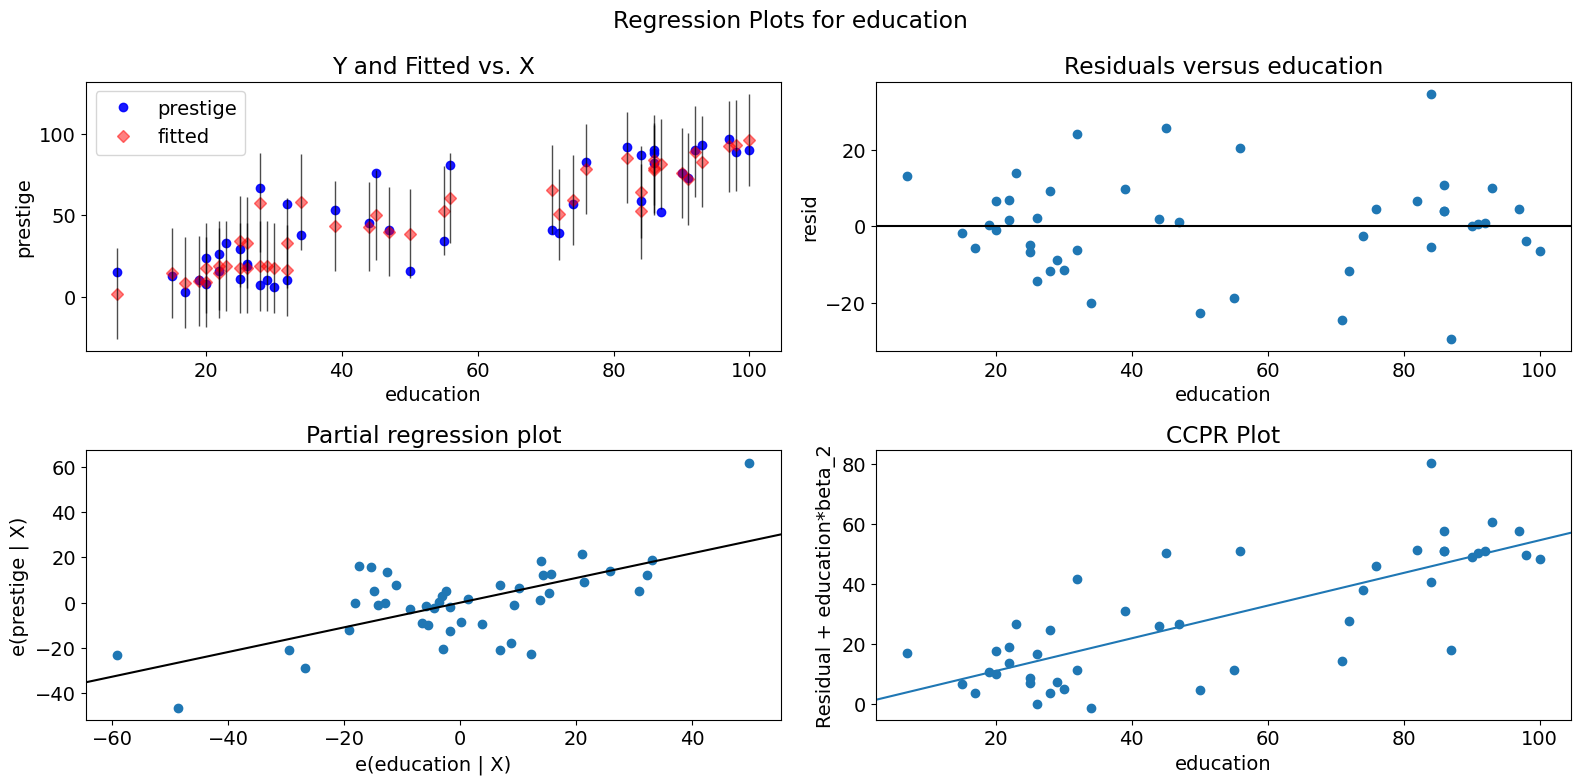

In [1204]:

fig = sm.graphics.plot_regress_exog(prestige_model, "education")

fig.tight_layout(pad=1.0)

### Fit Plot

The plot_fit function plots the fitted values versus a chosen independent variable. It includes prediction confidence intervals and optionally plots the true dependent variable.

>> - 画出拟合值和解释变量。

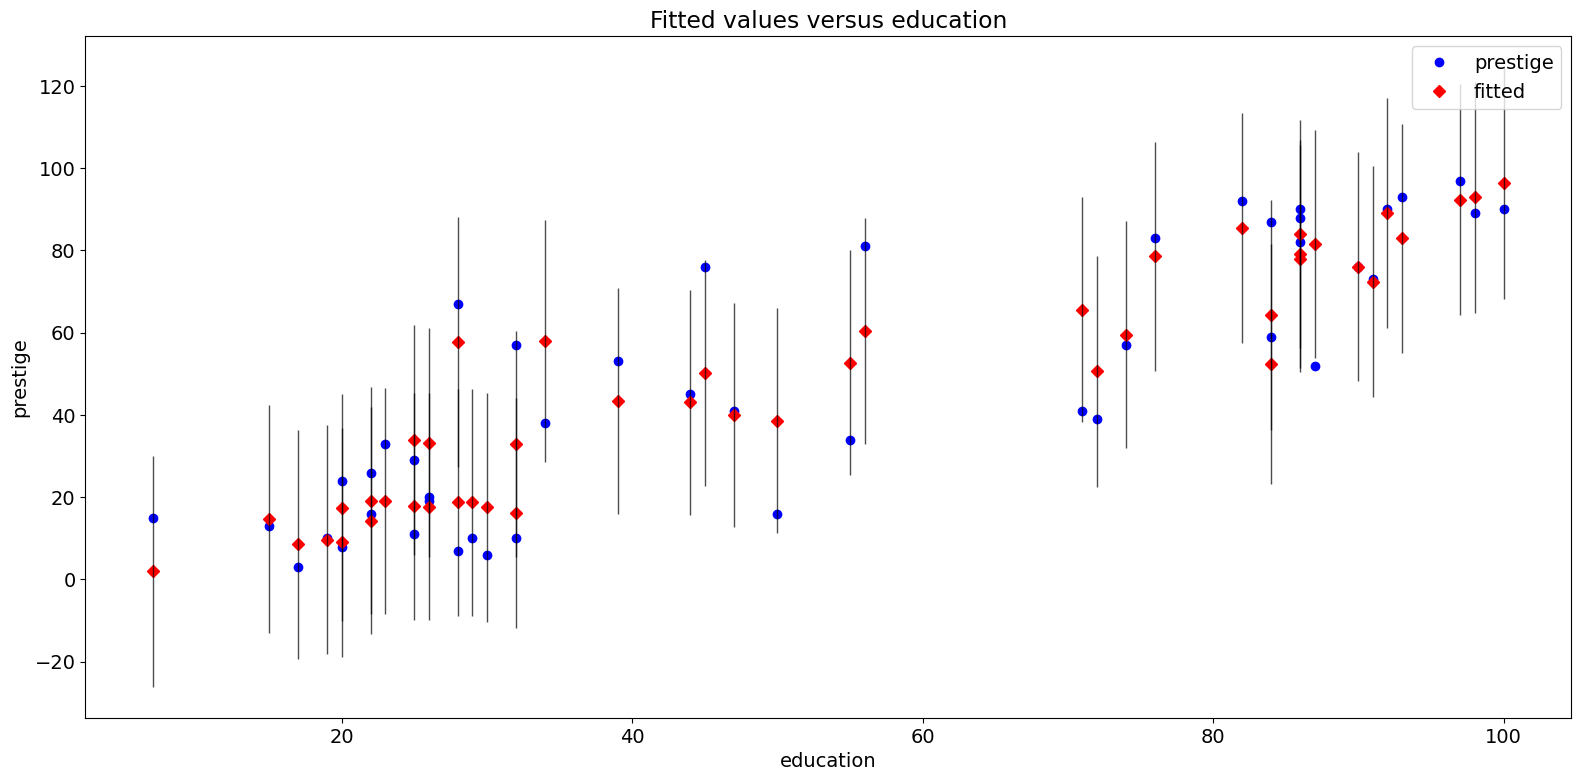

In [1205]:

fig = sm.graphics.plot_fit(prestige_model, "education")

fig.tight_layout(pad=1.0)

## Statewide Crime 2009 Dataset

In [1206]:
dta = sm.datasets.statecrime.load_pandas().data

dta.head(10)
# dta.info()
# dta.describe()

violent  murder  hs_grad  poverty  single  white   urban
state                                                                         
Alabama                 459.9     7.1     82.1     17.5    29.0   70.0   48.65
Alaska                  632.6     3.2     91.4      9.0    25.5   68.3   44.46
Arizona                 423.2     5.5     84.2     16.5    25.7   80.0   80.07
Arkansas                530.3     6.3     82.4     18.8    26.3   78.4   39.54
California              473.4     5.4     80.6     14.2    27.8   62.7   89.73
Colorado                340.9     3.2     89.3     12.9    21.4   84.6   76.86
Connecticut             300.5     3.0     88.6      9.4    25.0   79.1   84.83
Delaware                645.1     4.6     87.4     10.8    27.6   71.9   68.71
District of Columbia   1348.9    24.2     87.1     18.4    48.0   38.7  100.00
Florida                 612.6     5.5     85.3     14.9    26.6   76.9   87.44

In [1207]:
# 跑回归
crime_model = ols("murder ~ urban + poverty + hs_grad + single", data=dta).fit()

print(crime_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 murder   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     50.08
Date:                Thu, 25 Jul 2024   Prob (F-statistic):           3.42e-16
Time:                        18:55:15   Log-Likelihood:                -95.050
No. Observations:                  51   AIC:                             200.1
Df Residuals:                      46   BIC:                             209.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -44.1024     12.086     -3.649      0.0

### Partial Regression Plots (Crime Data)

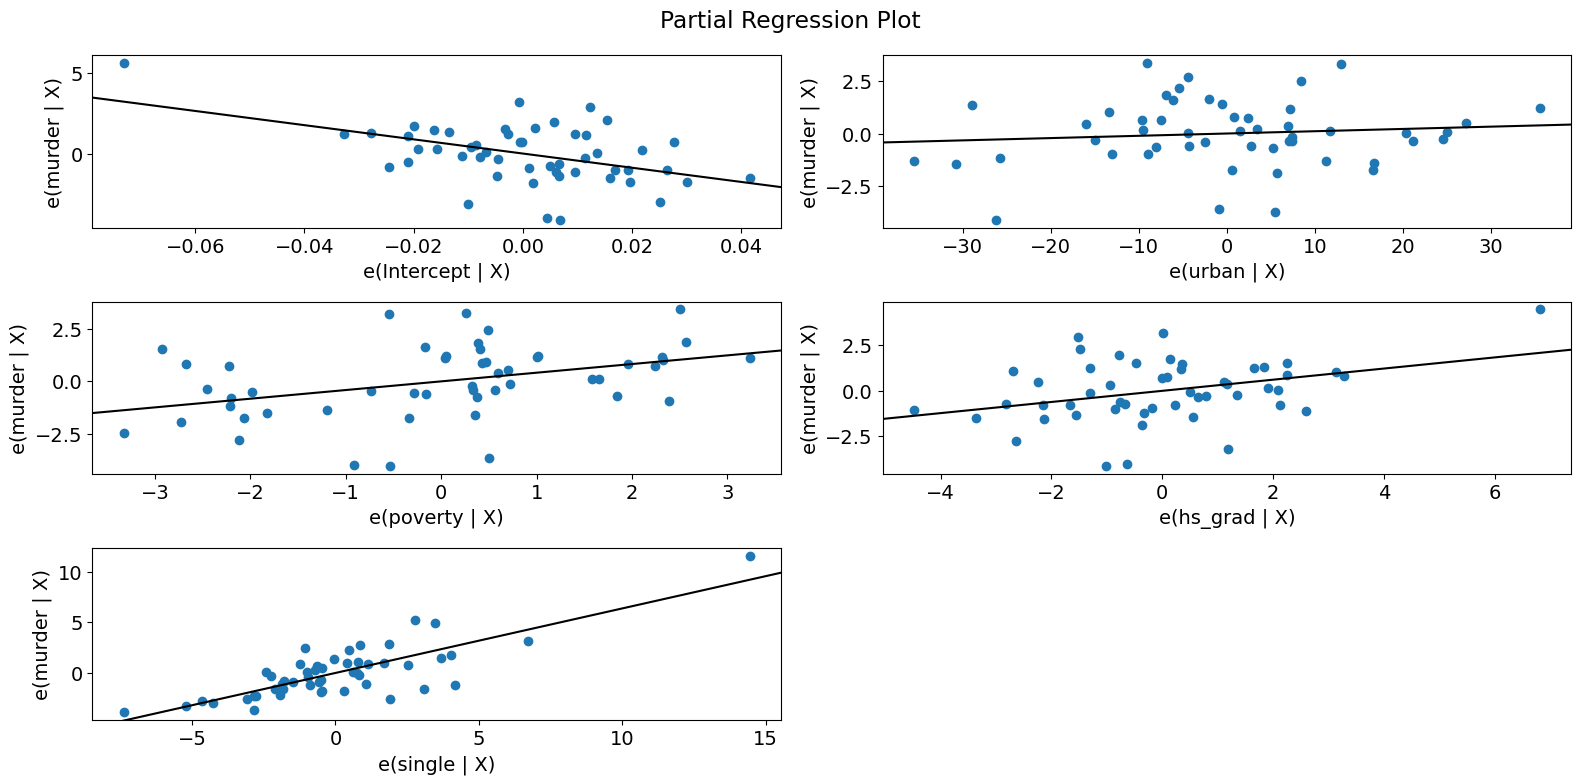

In [1208]:

fig = sm.graphics.plot_partregress_grid(crime_model)

fig.tight_layout(pad=1.0)

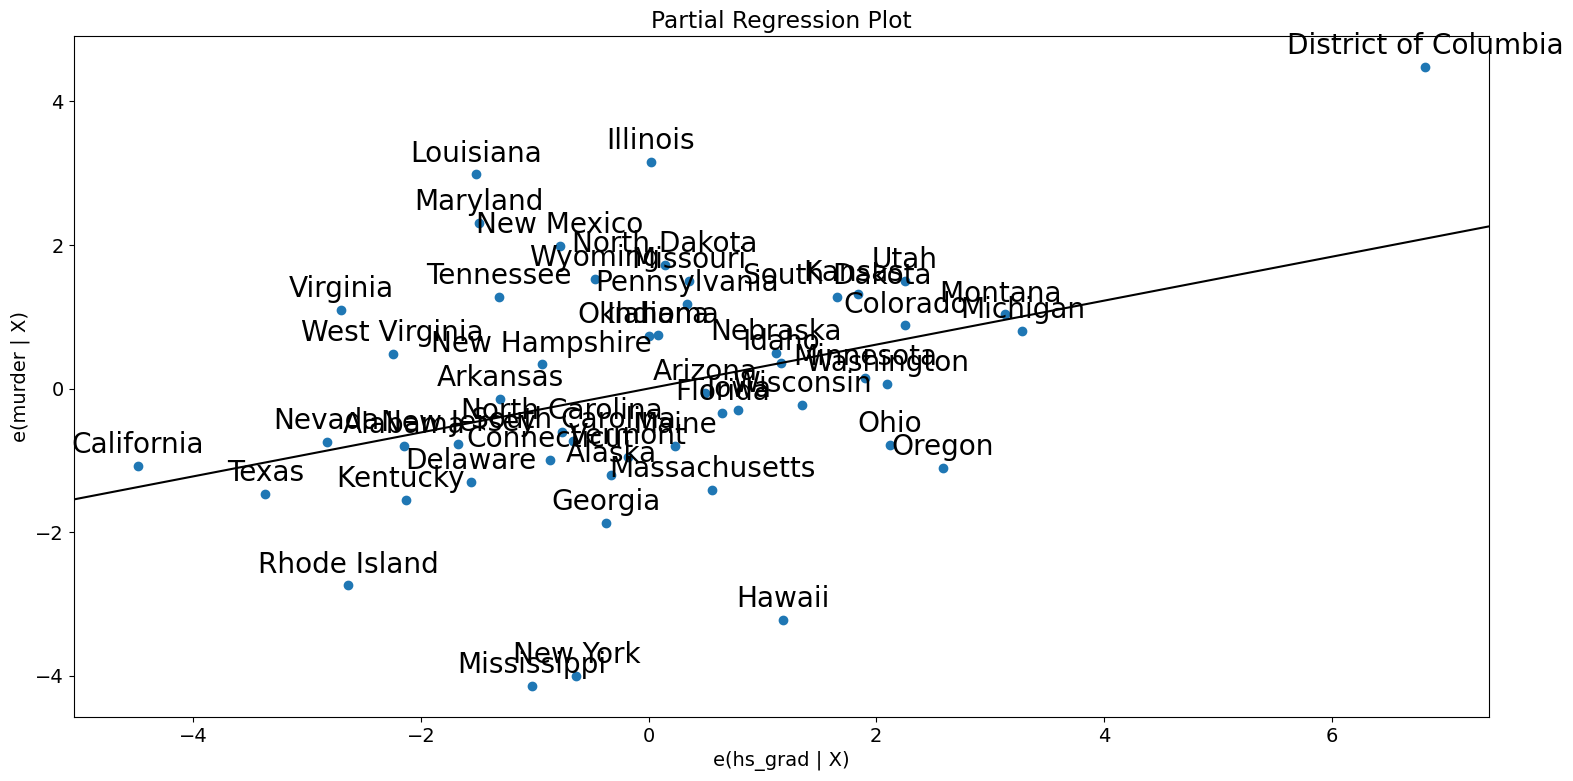

In [1209]:
fig = sm.graphics.plot_partregress(
    "murder", "hs_grad", ["urban", "poverty", "single"], data=dta
)
fig.tight_layout(pad=1.0)

### Leverage-Resid<sup>2</sup> Plot

Closely related to the influence_plot is the leverage-resid<sup>2</sup> plot.

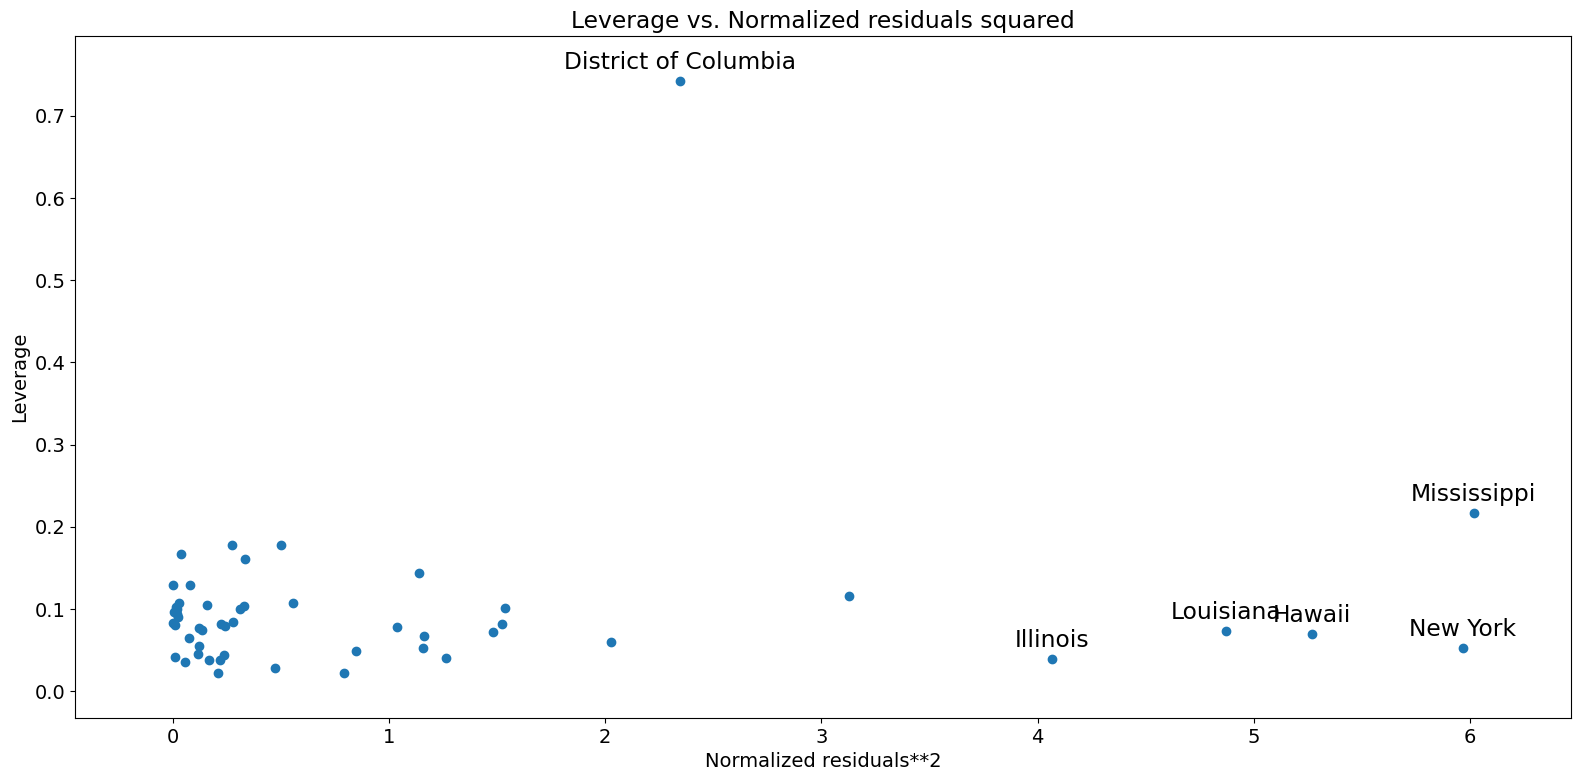

In [1210]:
# 画leverage和正态化的残差分布图
fig = sm.graphics.plot_leverage_resid2(crime_model)

fig.tight_layout(pad=1.0)

### Influence Plot

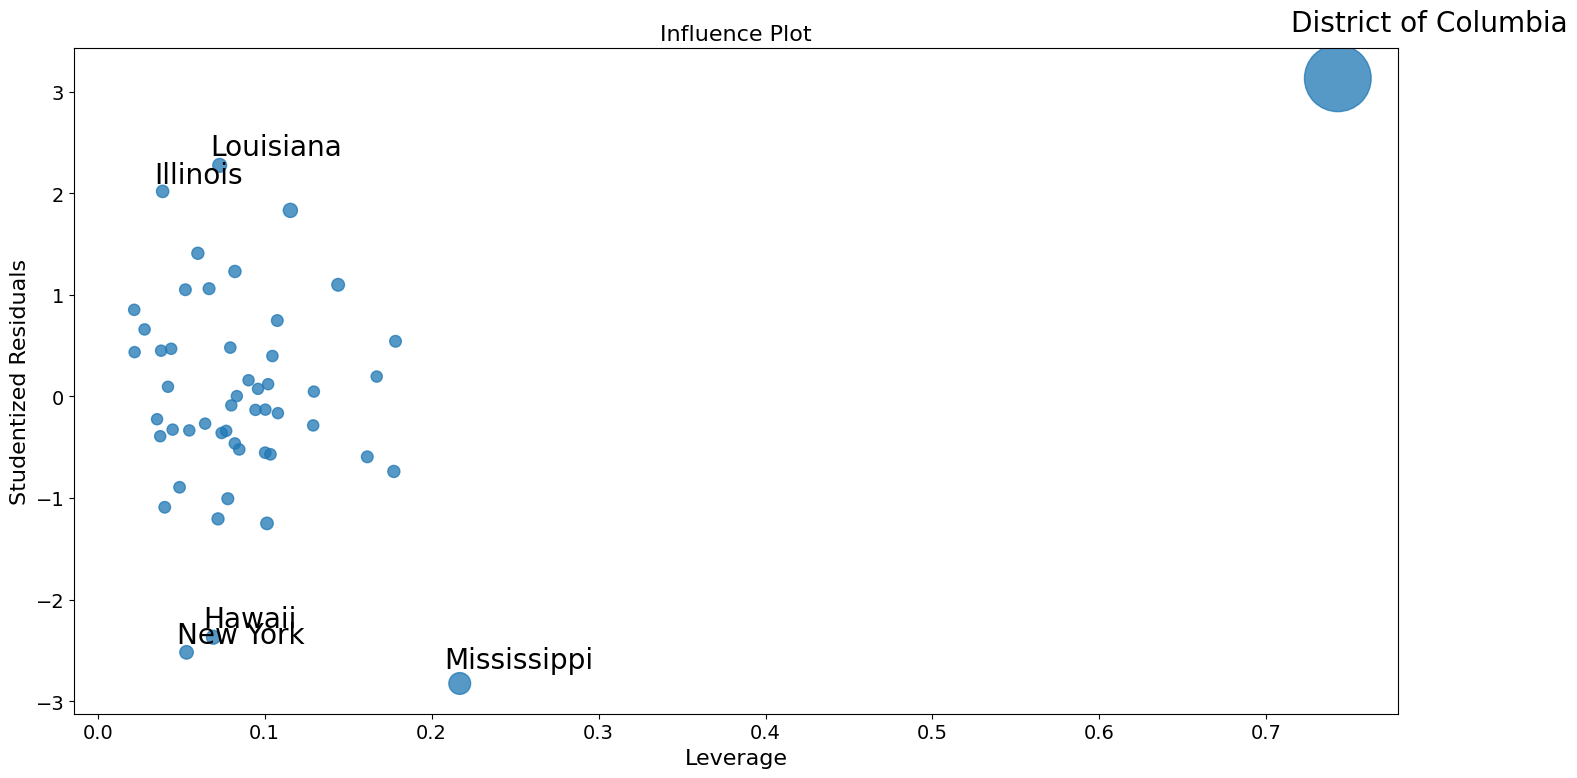

In [1211]:
fig = sm.graphics.influence_plot(crime_model,size=48)
fig.tight_layout(pad=1.0)

### Using robust regression to correct for outliers.

Part of the problem here in recreating the Stata results is that M-estimators are not robust to leverage points. MM-estimators should do better with this examples.

In [1212]:
from statsmodels.formula.api import rlm

In [1213]:
# conv = convergence criteria
rob_crime_model = rlm(
    "murder ~ urban + poverty + hs_grad + single",
    data=dta,
    M=sm.robust.norms.TukeyBiweight(3),
).fit(conv="weights")


print(rob_crime_model.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 murder   No. Observations:                   51
Model:                            RLM   Df Residuals:                       46
Method:                          IRLS   Df Model:                            4
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 25 Jul 2024                                         
Time:                        18:55:16                                         
No. Iterations:                    50                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.2986      9.494     -0.453      0.6

There is not yet an influence diagnostics method as part of RLM, but we can recreate them. (This depends on the status of [issue #888](https://github.com/statsmodels/statsmodels/issues/808))

>> - 自己手动写一个函数

In [1214]:
# 回归的结果权重赋值
weights = rob_crime_model.weights
# 设置一个dummy
idx = weights > 0
# 只把权重大于0的提取出来
X = rob_crime_model.model.exog[idx.values]
# 提取大于0的权重。并计算这些权重的均值
ww = weights[idx] / weights[idx].mean()
# np.linalg.pinv(X)：计算矩阵 X 的伪逆矩阵。
# .sum(1)：按行求和，得到帽子矩阵的对角线元素。
hat_matrix_diag = ww * (X * np.linalg.pinv(X).T).sum(1)
# 提取残差
resid = rob_crime_model.resid
# 计算平方
resid2 = resid ** 2
# 算出来各个周残差占总和多少
resid2 /= resid2.sum()
# 把dummy求和取整
nobs = int(idx.sum())
# 算出来hm & rm
hm = hat_matrix_diag.mean()
rm = resid2.mean()

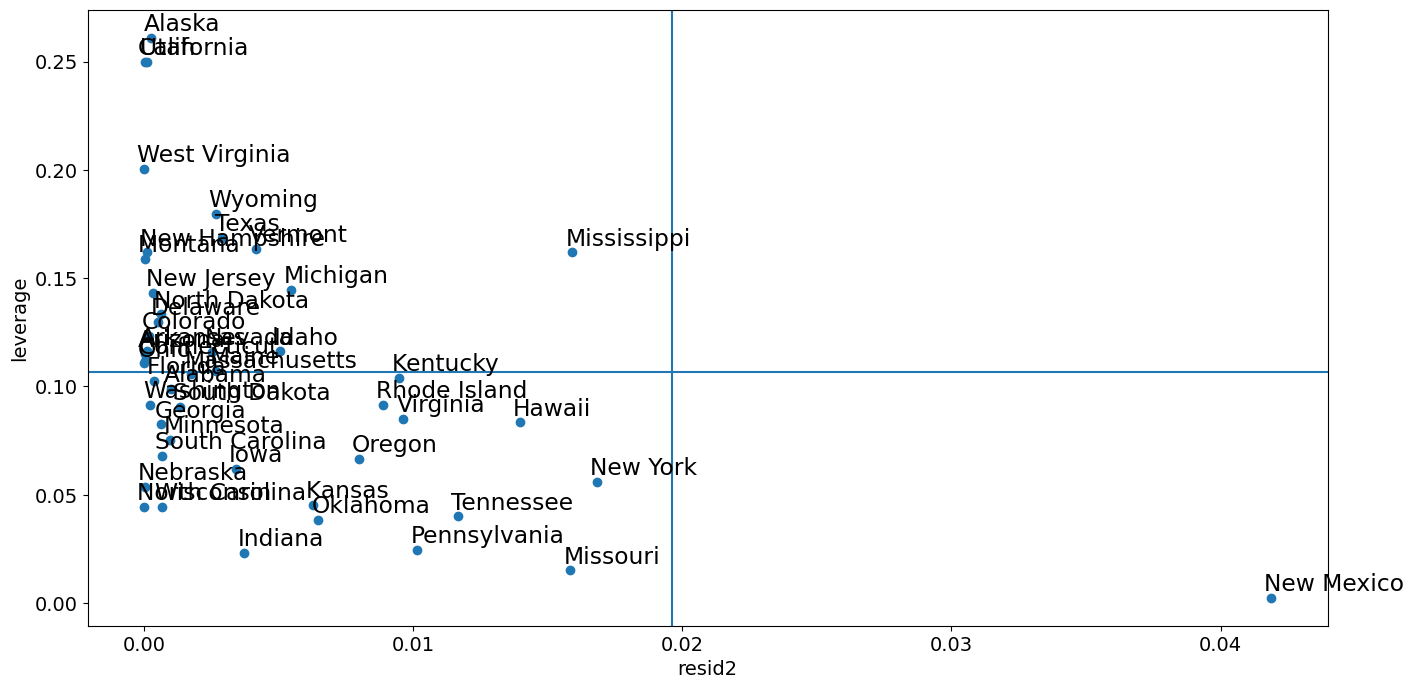

In [1215]:
from statsmodels.graphics import utils

#创建图形框和子图
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(resid2[idx], hat_matrix_diag, "o")

# 给图形添加注释
ax = utils.annotate_axes(
    range(nobs), # 从0开始，到nob（dummy求和）
    labels=rob_crime_model.model.data.row_labels[idx], # dummy>0 的那些
    points=lzip(resid2[idx], hat_matrix_diag),  # x是残差平方，y是leverage
    offset_points=[(-5, 5)] * nobs,  # 为每个标注点设置偏移量，使标注位置更美观。
    size="large", 
    ax=ax,
)

#设置x轴标签
ax.set_xlabel("resid2")
#设置y轴标签
ax.set_ylabel("leverage")
#获取当前y轴的范围
ylim = ax.get_ylim()
#画一条垂直的线rm是横坐标，*ylim是纵坐标范围。*ylim表示解析ylim这个范围。
ax.vlines(rm, *ylim)

xlim = ax.get_xlim()

ax.hlines(hm, *xlim)

ax.margins(0, 0)